Processing Singapore...
Road network loading time:  19.97209668159485


Iterations..: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [15:26<00:00,  3.09s/it]


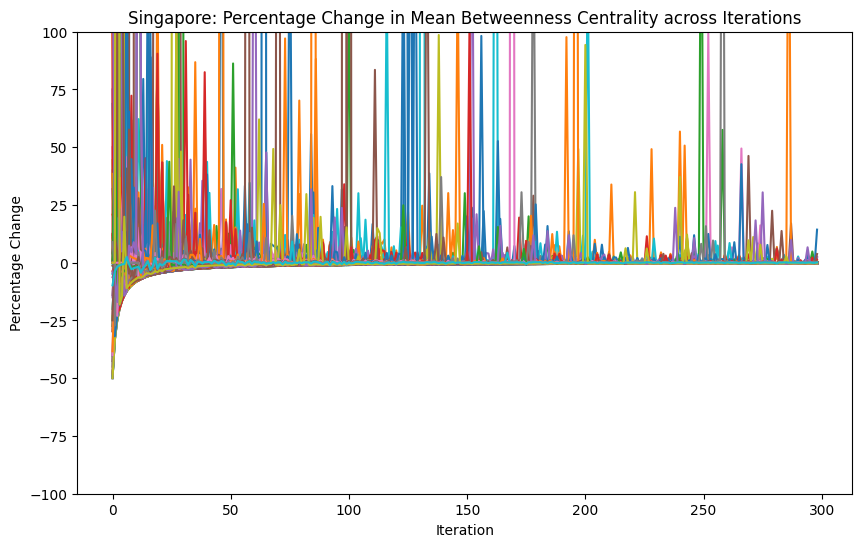

len(overall_mean_bc_per_node), len(G.nodes()) : 249222 249222
Processing Zurich...
Road network loading time:  37.92553496360779


Iterations..:   3%|█████▍                                                                                                                                                                               | 9/300 [00:53<29:29,  6.08s/it]

In [ ]:
import copy
import os
import pickle
import time
import glob
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import sys

sys.path.append("../..")
import config
from urbanscales.io.road_network import RoadNetwork
from urbanscales.preprocessing.prep_network import Scale
from urbanscales.preprocessing.prep_speed import ScaleJF
from urbanscales.preprocessing.tile import Tile
import pandas as pd
from tqdm import tqdm

from smartprint import smartprint as sprint
from slugify import slugify

import networkx as nx
import matplotlib.pyplot as plt
import random
import tqdm
import pickle

rn_city_wise_tz_code = {
    "Singapore": "Asia/Singapore",
    "Zurich": "Europe/Zurich",
    "Mumbai": "Asia/Kolkata",
    "Auckland": "Pacific/Auckland",
    "Istanbul": "Europe/Istanbul",
    "MexicoCity": "America/Mexico_City",
    "Bogota": "America/Bogota",
    "NewYorkCity": "America/New_York",
    "Capetown": "Africa/Johannesburg",
    "London": "Europe/London"
}

K = 2
iterations = 300
num_random_nodes = 200

for city, _ in rn_city_wise_tz_code.items():
    print(f"Processing {city}...")

    # Assuming the Scale.get_object method works for every city
    G = RoadNetwork.get_object(city).G_osm

    initial_bc = nx.betweenness_centrality(G, k=K)
    all_nodes = list(initial_bc.keys())
    random_nodes = random.sample(list(initial_bc.keys()), num_random_nodes)
    

    # Dictionary to store the mean betweenness centrality values for each node up to each iteration
    mean_values_per_node = {node: [] for node in all_nodes}

    for i in tqdm.tqdm(range(iterations), desc="Iterations.."):
        bc = nx.betweenness_centrality(G, k=K)
        for node in all_nodes:
            if i == 0:
                current_mean = bc[node]
            else:
                current_mean = (mean_values_per_node[node][-1] * i + bc[node]) / (i + 1)
            mean_values_per_node[node].append(current_mean)

    # Compute the percentage change in mean values across iterations for each node
    percentage_changes_per_node = {node: [] for node in all_nodes}
    
    plt.figure(figsize=(10, 6))
    for node in random_nodes:
        mean_values = mean_values_per_node[node]
        percentage_changes = []
        for i in range(1, len(mean_values)):
            if mean_values[i-1] != 0:
                percentage_change = ((mean_values[i] - mean_values[i-1]) / mean_values[i-1]) * 100
            else:
                percentage_change = np.nan
            percentage_changes.append(percentage_change)
        percentage_changes_per_node[node] = percentage_changes

        # Plot the percentage change in mean values for the current node
 
        plt.plot(percentage_changes) # , label=f'Node {node}', marker='o')

    plt.ylim(-100, 100)
    plt.xlabel('Iteration')
    plt.ylabel('Percentage Change')
    plt.title( city + ': Percentage Change in Mean Betweenness Centrality across Iterations')        
    plt.show()

    # Save mean betweenness centrality results for the city to a pickle file
    overall_mean_bc_per_node = {node: sum(values) / len(values) for node, values in mean_values_per_node.items()}
    sprint(len(overall_mean_bc_per_node), len(G.nodes()))
    with open(os.path.join(config.BASE_FOLDER, config.network_folder, \
                               city + "_mean_betweenness_centrality.pkl"), "wb") as f:
        pickle.dump(overall_mean_bc_per_node, f)

print("Finished processing all cities.")